In [1]:
%load_ext tensorboard

In [2]:
%matplotlib inline


import numpy as np
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"]=30,30
import pandas as pd
import os
import glob
import scipy.io
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import datetime 
import time

import torch
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.tensorboard import SummaryWriter
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

from torchsummary import summary
import copy

import src.functions as fn

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('this computation is running on {}'.format(device))
device_name = str(device)[:3]



this computation is running on cuda:0


In [4]:
# open ascii txt:
filename = "../data/romantische_lieder_hermannhesse.txt"
text_corpus = open(filename, 'r', encoding='utf-8').read()

raw_text = text_corpus
print('text has %i characters before cleaning'%len(raw_text))
vocab = sorted(set(raw_text))
char_to_int = dict((c, i) for i, c in enumerate(vocab))
print('len vocab: ',len(vocab))
print('\nvocabulary before cleaning:\n'+str(vocab))
char_counting = dict((c,raw_text.count(c)) for i,c in enumerate(vocab))
print('char_counting: ',char_counting)

text has 33440 characters before cleaning
len vocab:  72

vocabulary before cleaning:
['\n', ' ', '!', "'", '(', ')', ',', '-', '.', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'Z', '^', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '«', '»', 'Ä', 'Ö', 'Ü', 'ß', 'ä', 'ö', 'ü']
char_counting:  {'\n': 1444, ' ': 6872, '!': 61, "'": 87, '(': 3, ')': 3, ',': 423, '-': 133, '.': 320, ':': 9, ';': 21, '?': 20, 'A': 96, 'B': 88, 'C': 3, 'D': 311, 'E': 79, 'F': 88, 'G': 89, 'H': 152, 'I': 129, 'J': 19, 'K': 70, 'L': 115, 'M': 137, 'N': 58, 'O': 12, 'P': 30, 'Q': 2, 'R': 47, 'S': 222, 'T': 89, 'U': 155, 'V': 47, 'W': 149, 'Z': 30, '^': 12, 'a': 1085, 'b': 362, 'c': 814, 'd': 1086, 'e': 3634, 'f': 225, 'g': 520, 'h': 1126, 'i': 1880, 'j': 17, 'k': 268, 'l': 873, 'm': 781, 'n': 2754, 'o': 488, 'p': 93, 'q': 1, 'r': 1521, 's': 100

number of poems =  45
how many poems have subpoems =  12
number of subpoems = 24
number of stanzas =  202
mean of lines in stanza =  4.52970297029703
std of lines of stanzas = 1.5925597151839614
[6, 9, 11, 16, 18, 22, 25, 28, 40, 43, 46, 50, 55, 59, 66, 72, 75, 78, 80, 83, 87, 89, 91, 98, 102, 105, 110, 115, 121, 125, 130, 132, 135, 138, 141, 146, 149, 157, 165, 166, 171, 178, 182, 186, 190, 195, 196, 198, 199, 201]
[3, 2, 5, 2, 4, 3, 3, 12, 3, 3, 4, 5, 4, 7, 6, 3, 3, 2, 3, 4, 2, 2, 7, 4, 3, 5, 5, 6, 4, 5, 2, 3, 3, 3, 5, 3, 8, 8, 1, 5, 7, 4, 4, 4, 5, 1, 2, 1, 2]
stanza mean =  3.979591836734694
stanza std =  2.0750195073424558


(0.0, 202.0)

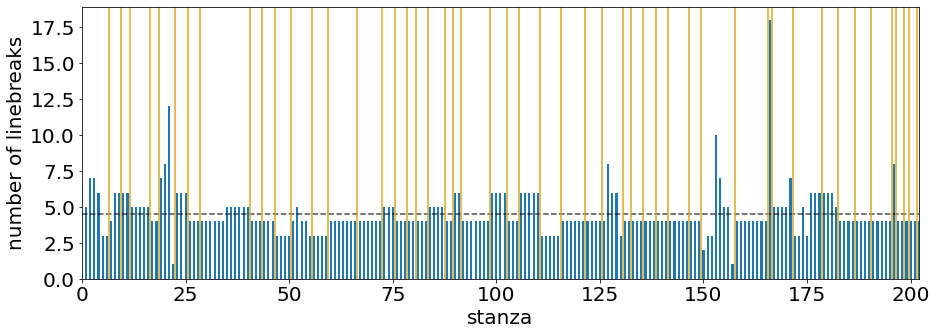

In [5]:
# how many poems in text?
# string that separated poems
sep_string = '\n\n\n\n\n'
nr_poems = text_corpus.count(sep_string)
print('number of poems = ',nr_poems)

# before counting the stanzas we have to get rid of the subtitles of some stanzas
# luckily they are numbered:
# I don't know why, but only got rid of I., II., ... numberation when I replaced the following:
sub_numberation = ['I.', 'II.', 'III.', 'IV.', 'V.', 'VI.','I\n\n', 'II\n\n', 'III\n\n', 'IV\n\n', 'V\n\n', 'VI\n\n', 'I\n\n']

sub_poems = 0
for sub in sub_numberation:
    if sub=='I.':
        print('how many poems have subpoems = ', str(text_corpus.count(sub)))
    sub_poems += text_corpus.count(sub)
print('number of subpoems =' , sub_poems)

# data cleansing: replace unnecessary characters and line breaks
# (in prediction too much linebreaks after each other leads to linebreak as prediction)
stanza = copy.copy(text_corpus)

for num in sub_numberation:
    stanza = stanza.replace(num, "\n")
    
end_sentence_char = ['_',':', '$', '*', '/','(',')', "'", '-', '^', '»', '«']
for char in end_sentence_char:
    stanza = stanza.replace(char, "")
    
# delete citization from text:
zitat_in = 'Ich habe den Fuß an jene Stelle des Lebens gesetzt,'
zitat_out = 'Dante'
inso = stanza.find(zitat_in)
outso = stanza.find(zitat_out)
stanza = stanza.replace(stanza[inso:outso+6], '')

stanza = stanza.replace('\n\n\n\n','\n')
stanza = stanza.replace('\n\n\n','\n')

# correction of some subtitle in order to match poemtitle - poem schematic
stanza = stanza.replace('Villalilla.\n', 'Villalilla.')
stanza = stanza.replace('Berceuse.\n\n', '\nBerceuse.\n')
stanza = stanza.replace('Grande valse.\n\n', 'Grande valse.\n')
stanza = stanza.replace('Du aber.\n\n', '\nDu aber.\n')
stanza = stanza.replace('Ich fragte Dich.\n\n', '\nIch fragte Dich.\n')
stanza = stanza.replace('Wenn doch mein Leben \n\n', '\nWenn doch mein Leben.\n')
stanza = stanza.replace('So ziehen Sterne \n\n', '\nSo ziehen Sterne.\n')
stanza = stanza.replace('So schön bist Du!\n\n', 'So schön bist Du!\n')
num_stanza = stanza.count('\n\n')
print('number of stanzas = ', num_stanza)

# number of lines per stanza
import re
# indeces of where begin
stanza_pos = [m.start() for m in re.finditer('\n\n', stanza)]

#count number of three white spaces which is new line in poem
stanza_len = [stanza[0:stanza_pos[0]].count('   ')]
for i in range(0,len(stanza_pos)-1):
    stanza_count = stanza[stanza_pos[i]:stanza_pos[i+1]].count('   ')
    stanza_len.append(stanza_count)

mean_len= np.mean(stanza_len)

# position of title
# stanza pos includes also title plus first stanza of poem
# by searching position of poem entries(rhyme_pos) and an xor of both position
# we get position of title
rhyme_pos = [m.start() for m in re.finditer('\n\n   ', stanza)]
diff = sorted(set(stanza_pos)^set(rhyme_pos)) # bitwise XOR excludes position of title

title_pos=[]
for pos in diff:
    title_index = np.argwhere(np.array(stanza_pos)==pos)+1
    title_pos.append(title_index[0][0])

# plot
print('mean of lines in stanza = ',mean_len)
print('std of lines of stanzas =', np.std(stanza_len))
number_stanza = []
print(title_pos)
for i in range(0,len(title_pos)-1):
    diff_pos = title_pos[i+1]-title_pos[i]
    number_stanza.append(diff_pos)
print(number_stanza)
print('stanza mean = ',np.mean(number_stanza)) #how many stanza there is 
print('stanza std = ', np.std(number_stanza))

plt.figure(figsize=(15,5))
xs = np.arange(1,len(stanza_pos)+1)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.bar(xs,stanza_len, width=0.5)
plt.xlabel('stanza', fontsize=20)
plt.ylabel('number of linebreaks', fontsize=20)
plt.axhline(mean_len, color='k', linestyle='--', alpha=0.7)
for title in title_pos:
    plt.axvline(title+0.5, color='goldenrod')
    
plt.xlim(0,202)
#plt.savefig('Pictures/poem_stanza_bar.pdf', format='pdf')

In [20]:
# number of characters per stanza:
#print(rhyme_pos)
line_begin = stanza_pos = [m.start() for m in re.finditer('\n   ', stanza)]
char_stanza = []
for i in range(0,len(line_begin)-1):
    diff_char = line_begin[i+1]-line_begin[i]
    char_stanza.append(diff_char)
print(np.mean(char_stanza))
print(np.std(char_stanza))


35.800219538968165
7.991051523570067


140

In [6]:
raw_text = stanza
vocab = sorted(set(raw_text))
char_to_int = dict((c, i) for i, c in enumerate(vocab))
print('len vocab: ',len(vocab))
print('number of characters after cleansing = ', len(stanza))

len vocab:  64
number of characters after cleansing =  32663


In [161]:
text_file = open("data/rl_stanza.txt", "w")
n = text_file.write(stanza)
text_file.close()

In [168]:
test_text = '   hey hir ist auch text\n\nkoala.\n   koalas sind toll.\n   superio\n\n   echt super\n   hio\n\nbirne.'
print(test_text)
print(test_text.find('\n\n'))
print(test_text.find('\n\n   '))

   hey hir ist auch text

koala.
   koalas sind toll.
   superio

   echt super
   hio

birne.
24
64


In [15]:
from sklearn.manifold import TSNE
#  sklearn TSNE:  
#  n:Dimension of embedded space
#  verbose: how many information are printed
#  perplexity: lower number gives more distance of nearest neighbor inside cluster
#  n_iter: maximum number of iterations
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(token[0])

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 32610 samples in 0.003s...
[t-SNE] Computed neighbors for 32610 samples in 57.563s...
[t-SNE] Computed conditional probabilities for sample 1000 / 32610
[t-SNE] Computed conditional probabilities for sample 2000 / 32610
[t-SNE] Computed conditional probabilities for sample 3000 / 32610
[t-SNE] Computed conditional probabilities for sample 4000 / 32610
[t-SNE] Computed conditional probabilities for sample 5000 / 32610
[t-SNE] Computed conditional probabilities for sample 6000 / 32610
[t-SNE] Computed conditional probabilities for sample 7000 / 32610
[t-SNE] Computed conditional probabilities for sample 8000 / 32610
[t-SNE] Computed conditional probabilities for sample 9000 / 32610
[t-SNE] Computed conditional probabilities for sample 10000 / 32610
[t-SNE] Computed conditional probabilities for sample 11000 / 32610
[t-SNE] Computed conditional probabilities for sample 12000 / 32610
[t-SNE] Computed conditional probabilities for s

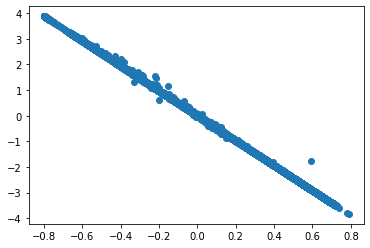

In [26]:
plt.scatter(tsne_plot[0], tsne_plot[1])